# Cross Section for Many Lines using MODIT

Update: October 30/2022, Hajime Kawahara

We demonstarte the Modified Discrete Integral Transform (MODIT), which is the modified version of DIT for exojax. MODIT uses the evenly-spaced logarithm grid (ESLOG) as a wavenumber dimension. MODIT takes advantage especially for the case that the number of the molecular line is large (typically > 10,000). We here compare the results by MODIT with the direct computation (LPF).

Here, we use FP64, but if you want you can use FP32 (but slightly large errors):

In [1]:
from jax import config

config.update("jax_enable_x64", True)

In [4]:
import matplotlib.pyplot as plt
from exojax.spec.hitran import line_strength, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import api
from exojax.utils.grids import wavenumber_grid
from exojax.utils.constants import Tref_original

# Setting wavenumber bins and loading HITRAN database
nus, wav, R = wavenumber_grid(1900.0, 2300.0, 350000, unit="cm-1", xsmode="modit")
mdbCO = api.MdbHitran("CO", nus, isotope=1)  # use isotope=1 12C-16O

# set T, P and partition function
Mmol = mdbCO.molmass
Tfix = 1000.0  # we assume T=1000K
Pfix = 1.0e-3  # we compute P=1.e-3 bar
Ppart = Pfix  # partial pressure of CO. here we assume a 100% CO atmosphere

xsmode =  modit
xsmode assumes ESLOG in wavenumber space: xsmode=modit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
radis engine =  vaex


In [6]:
qt = mdbCO.qr_interp(1, Tfix, Tref_original)  # isotope=1

# computes logsij0 etc in device
mdbCO.generate_jnp_arrays()
# compute Sij, gamma_L, sigmaD
Sij = line_strength(
    Tfix, mdbCO.logsij0, mdbCO.nu_lines, mdbCO.elower, qt, Tref_original
)
gammaL = gamma_hitran(
    Pfix, Tfix, Ppart, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self
) + gamma_natural(mdbCO.A)

MODIT uses the normalized quantities by wavenumber/R, where R is the spectral resolution. In this case, the normalized Doppler width (nsigmaD) is common for the same isotope. Then, we use a 2D DIT grid with the normalized gammaL and q = R log(nu).

In [7]:
from exojax.spec.hitran import normalized_doppler_sigma

dv_lines = mdbCO.nu_lines / R
nsigmaD = normalized_doppler_sigma(Tfix, Mmol, R)
ngammaL = gammaL / dv_lines

MODIT uses a grid of ngammaL, and wavenumber. set_ditgrid.ditgrid_log_interval makes a 1D grid (evenly log spaced) for ngamma.

In [8]:
from exojax.spec.set_ditgrid import ditgrid_log_interval

ngammaL_grid = ditgrid_log_interval(ngammaL)

Text(0, 0.5, 'normalized gammaL')

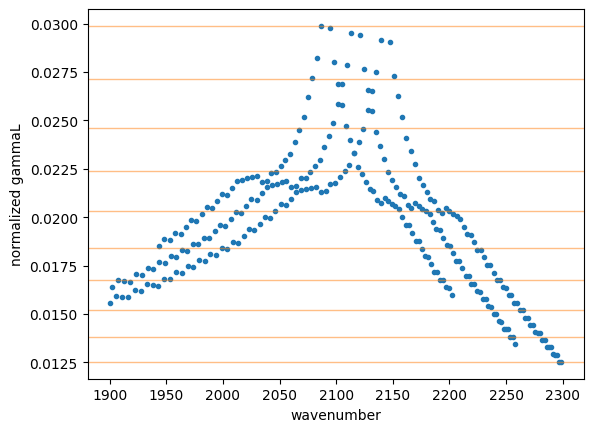

In [9]:
# show the grids
plt.plot(mdbCO.nu_lines, ngammaL, ".")
for i in ngammaL_grid:
    plt.axhline(i, lw=1, alpha=0.5, color="C1")
plt.xlabel("wavenumber")
plt.ylabel("normalized gammaL")

We need to precompute the contribution for wavenumber and pmarray. These can be computed using init_dit. 

In [10]:
from exojax.spec import initspec

cnu, indexnu, R, pmarray = initspec.init_modit(mdbCO.nu_lines, nus)

Let's compute the cross section!

In [11]:
from exojax.spec.modit import xsvector

xs = xsvector(cnu, indexnu, R, pmarray, nsigmaD, ngammaL, Sij, nus, ngammaL_grid)

Also, we here try the direct computation using LPF for the comparison purpose

In [12]:
from exojax.spec.opacalc import OpaDirect
opa = OpaDirect(mdbCO, nus)
xsv = opa.xsvector(Tfix, Pfix, Ppart)

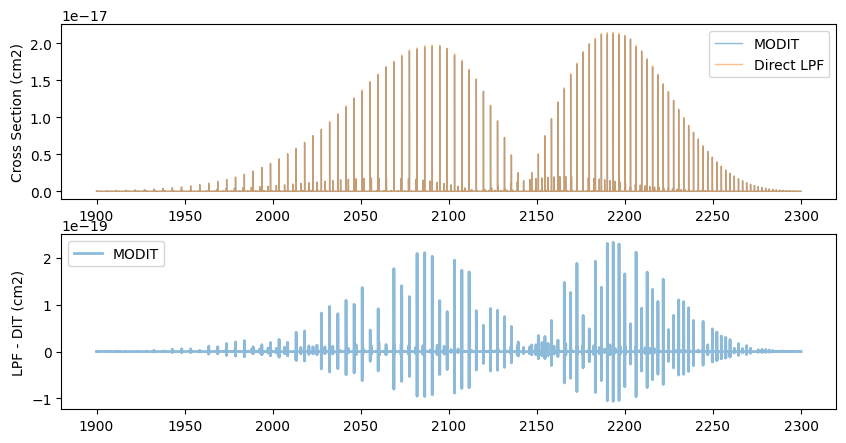

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(211)
plt.plot(nus, xs, lw=1, alpha=0.5, label="MODIT")
plt.plot(nus, xsv, lw=1, alpha=0.5, label="Direct LPF")
plt.legend(loc="upper right")
plt.ylabel("Cross Section (cm2)")
ax = fig.add_subplot(212)
plt.plot(nus, xsv - xs, lw=2, alpha=0.5, label="MODIT")
plt.ylabel("LPF - DIT (cm2)")
plt.legend(loc="upper left")
plt.show()

There is about 1 % deviation between LPF and MODIT. 

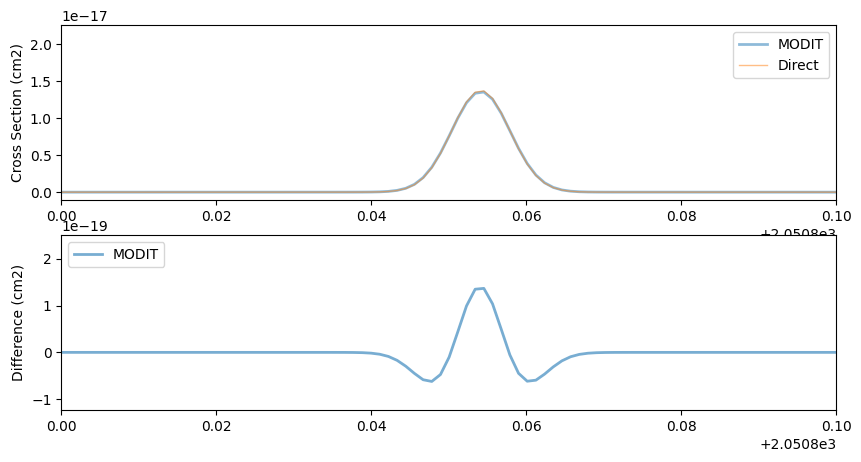

In [14]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(211)
plt.plot(nus, xs, lw=2, alpha=0.5, label="MODIT")
plt.plot(nus, xsv, lw=1, alpha=0.5, label="Direct")
plt.legend(loc="upper right")
plt.xlim(2050.8, 2050.9)
plt.ylabel("Cross Section (cm2)")
ax = fig.add_subplot(212)
plt.plot(nus, xsv - xs, lw=2, alpha=0.6, label="MODIT")
plt.legend(loc="upper left")
plt.ylabel("Difference (cm2)")
plt.xlim(2050.8, 2050.9)
# plt.yscale("log")
plt.savefig("fine_grid.png")